## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)


# Setup

## Import modules

In [1]:
# ignore deprication warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# standard python modules
import os, sys
import time


# standard ml modules
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, colors
# work in interactive moode
%matplotlib inline 


# loading files (in parallel)
from pathlib import Path
from multiprocessing.pool import ThreadPool


# working with images
import PIL
from PIL import Image
from skimage import io

# preprocessing
from sklearn.preprocessing import LabelEncoder


# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
# torchvision
import torchvision
from torchvision import transforms


# interacrive timimg
from tqdm import tqdm, tqdm_notebook

# saving models 
import pickle
import copy

In [2]:
print(PIL.__version__)

7.2.0


In [3]:
print("torch.__version__ :", torch.__version__)
print("torchvision.__version__ :", torchvision.__version__)

torch.__version__ : 1.5.1
torchvision.__version__ : 0.6.0a0+35d732a


## Choose training device

In [4]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


* ## Set device, 

In [5]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
DEVICE

device(type='cuda')

In [7]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Preparing the Data

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:

$input = \frac{input - \mu}{\text{standard deviation}} $,

константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

## Class for loading the data from folders in parallel

In [8]:
class SimpsonsDataset(Dataset):
    """
    Class to work with image dastaset, which
    - loads them form the folders in parallel
    - converts to PyTorch tensors
    - scales the tensors to have mean = 0, standard deviation = 1
    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files) # list of files to be loaded
        self.mode = mode           # working mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                
    
    def __len__(self):
        return self.len_
    
    
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)
    
    
    def __getitem__(self, index):
        # converts to PyTorch tensors and normalises the input
        
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
            'val_test': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
        }

        transform = (data_transforms['train'] if self.mode == 'train' else data_transforms['val_test'])
        
        x = self.load_sample(self.files[index])  # load image
        x = transform(x)                         # apply transform defined above
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

## Get training filenames and labels

In [10]:
# Uncomment to check the directories

# %ls ../input/journey-springfield/testset/testset/
# %ls ../input/journey-springfield/train/simpsons_dataset/

In [11]:
TRAIN_DIR = Path('../input/journey-springfield/train/simpsons_dataset/')
TEST_DIR = Path('../input/journey-springfield/testset/testset/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*/*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
print(len(train_val_files), 'train files')
train_val_files[:5]

20933 train files


[PosixPath('../input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg'),
 PosixPath('../input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0001.jpg'),
 PosixPath('../input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0002.jpg'),
 PosixPath('../input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0003.jpg'),
 PosixPath('../input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0004.jpg')]

In [13]:
print(len(test_files), 'test files')
test_files[:5]

991 test files


[PosixPath('../input/journey-springfield/testset/testset/img0.jpg'),
 PosixPath('../input/journey-springfield/testset/testset/img1.jpg'),
 PosixPath('../input/journey-springfield/testset/testset/img10.jpg'),
 PosixPath('../input/journey-springfield/testset/testset/img100.jpg'),
 PosixPath('../input/journey-springfield/testset/testset/img101.jpg')]

In [14]:
# path.parent.name returns a folder in which the image is, which corresponds to the label in nthis case
train_val_labels = [path.parent.name for path in train_val_files]

In [15]:
print(len(train_val_labels), 'train_val_labels')
train_val_labels[:5]

20933 train_val_labels


['abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson']

# Training

## Train-Validation split

In [16]:
from sklearn.model_selection import train_test_split
train_files, val_files = train_test_split(train_val_files, test_size=0.20, stratify=train_val_labels)

## Validation dataset

In [17]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Let's have a look at the characters in the validation dataset

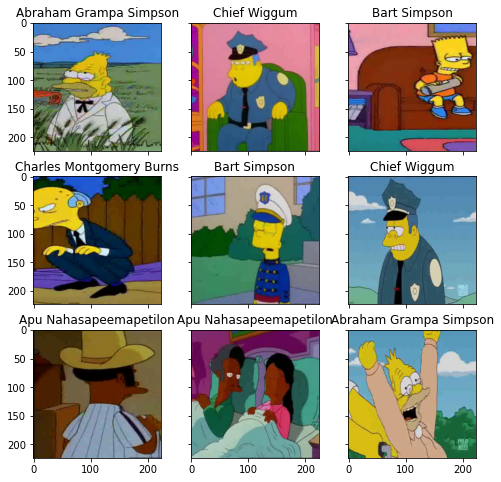

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Functions for training

In [19]:
def fit_epoch(model, train_loader, criterion, optimizer):
    # initialize tracked variables
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # reset the gradient
        optimizer.zero_grad()
        
        # predictions (probabilities), loss, backprop
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # weights update
        optimizer.step()
        
        # predictions (classes)
        preds = torch.argmax(outputs, 1)
        
        # record tracked items
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        
    # record train loss and train accuracy          
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [20]:
def eval_epoch(model, val_loader, criterion):
    # set model model into the evaluation mode (e.g. for Dropout)
    model.eval()
    
    # initialize tracked variables
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
        
        # record tracked items
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        
    # record val loss and val accuracy
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [21]:
def train(train_dataset, val_dataset, model, criterion,
          epochs, batch_size, optimizer, scheduler,
          shuffle=True, sampler=None, patience=5):
    
    # to record the total training time
    since = time.time()
    
    # note: 4 workers loading the data
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # init variables to store best model weights, best accuracy, best epoch number, epochs since best accuracy acheived
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    epochs_since_best = 0
    
    # history and log
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(1, epochs+1):
            print(f"epoch {epoch}:\n")
            
            print("Fitting on train data...")
            # all arguments except train loader are from parameters passed to train() arguments
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("train loss:", train_loss)
            
            print("Evaluating on validation data...")
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            print("val loss:", train_loss)
            
            # record history
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            # update learning rate for the optimizer
            scheduler.step()
            
            # display learning status
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            # deep copy the model if it acheives the best validation performance
            if val_acc > best_acc:
                best_acc = val_acc
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                print()
            else:
                epochs_since_best += 1
            
            # early stopping
            if epochs_since_best > patience:
                print(f'Stopping training. The validation accuracy has been decreasing for {patience} epochs.')
                break
            
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best epoch: {}'.format(best_epoch))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
            
    return history

In [22]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

# Training: fine-tuning pretrained resnet18

In [23]:
N_CLASSES = len(np.unique(train_val_labels))

In [24]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

## Training only the last layer

In [25]:
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, N_CLASSES)

# to GPU
model = model.to(DEVICE)

# loss
criterion = nn.CrossEntropyLoss()

# learning rate optimizer
optimizer = torch.optim.AdamW(model.parameters())

# scheduler for the lr optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, 0.5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [26]:
model.fc

Linear(in_features=512, out_features=42, bias=True)

In [27]:
history_feature_extr = train(train_dataset, val_dataset, model=model, criterion=criterion,
                             epochs=3, batch_size=256, optimizer=optimizer, scheduler=scheduler)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

epoch 1:

Fitting on train data...
train loss: 2.8502423126865826
Evaluating on validation data...


epoch:  33%|███▎      | 1/3 [02:45<05:30, 165.09s/it]

val loss: 2.8502423126865826

Epoch 002 train_loss: 2.8502     val_loss 2.4109 train_acc 0.2252 val_acc 0.3862

epoch 2:

Fitting on train data...
train loss: 2.2339994289763125
Evaluating on validation data...


epoch:  67%|██████▋   | 2/3 [05:23<02:43, 163.01s/it]

val loss: 2.2339994289763125

Epoch 003 train_loss: 2.2340     val_loss 1.9844 train_acc 0.4469 val_acc 0.5142

epoch 3:

Fitting on train data...
train loss: 1.9349747342361738
Evaluating on validation data...


epoch: 100%|██████████| 3/3 [08:02<00:00, 160.76s/it]

val loss: 1.9349747342361738

Epoch 004 train_loss: 1.9350     val_loss 1.7663 train_acc 0.5133 val_acc 0.5696

Training complete in 8m 2s
Best val Acc: 0.569620
Best epoch: 3


Plot learning curves

In [28]:
loss, acc, val_loss, val_acc = zip(*history_feature_extr)

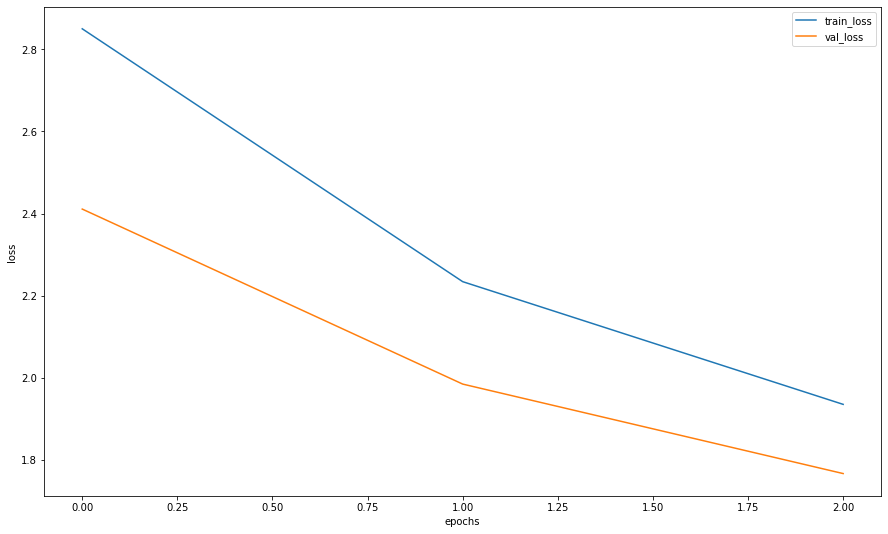

In [29]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Training all layers

In [30]:
for param in model.parameters():
    param.requires_grad = True

In [31]:
history_fine_tune = train(train_dataset=train_dataset, val_dataset=val_dataset, model=model, criterion=criterion,
                          epochs=50, batch_size=128, optimizer=optimizer, scheduler=scheduler)

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch 1:

Fitting on train data...
train loss: 3.343035994728705
Evaluating on validation data...


epoch:   2%|▏         | 1/50 [02:45<2:15:14, 165.61s/it]

val loss: 3.343035994728705

Epoch 002 train_loss: 3.3430     val_loss 3.1153 train_acc 0.1011 val_acc 0.1056

epoch 2:

Fitting on train data...
train loss: 3.0517825475235103
Evaluating on validation data...


epoch:   4%|▍         | 2/50 [05:30<2:12:19, 165.41s/it]

val loss: 3.0517825475235103

Epoch 003 train_loss: 3.0518     val_loss 2.9725 train_acc 0.1163 val_acc 0.1409

epoch 3:

Fitting on train data...
train loss: 2.828558953193073
Evaluating on validation data...


epoch:   6%|▌         | 3/50 [08:27<2:12:14, 168.83s/it]

val loss: 2.828558953193073

Epoch 004 train_loss: 2.8286     val_loss 2.5415 train_acc 0.1842 val_acc 0.2825

epoch 4:

Fitting on train data...
train loss: 2.48419007645077
Evaluating on validation data...


epoch:   8%|▊         | 4/50 [11:17<2:09:38, 169.11s/it]

val loss: 2.48419007645077

Epoch 005 train_loss: 2.4842     val_loss 2.1780 train_acc 0.2989 val_acc 0.3700

epoch 5:

Fitting on train data...
train loss: 2.054580236341198
Evaluating on validation data...


epoch:  10%|█         | 5/50 [14:05<2:06:42, 168.94s/it]

val loss: 2.054580236341198

Epoch 006 train_loss: 2.0546     val_loss 1.6608 train_acc 0.4283 val_acc 0.5426

epoch 6:

Fitting on train data...
train loss: 1.55950294329134
Evaluating on validation data...


epoch:  12%|█▏        | 6/50 [16:53<2:03:39, 168.63s/it]

val loss: 1.55950294329134

Epoch 007 train_loss: 1.5595     val_loss 1.2377 train_acc 0.5700 val_acc 0.6537

epoch 7:

Fitting on train data...
train loss: 1.1385377051225773
Evaluating on validation data...


epoch:  14%|█▍        | 7/50 [19:41<2:00:38, 168.33s/it]

val loss: 1.1385377051225773

Epoch 008 train_loss: 1.1385     val_loss 0.8836 train_acc 0.6866 val_acc 0.7614

epoch 8:

Fitting on train data...
train loss: 0.9628546139494316
Evaluating on validation data...


epoch:  16%|█▌        | 8/50 [22:29<1:57:42, 168.17s/it]

val loss: 0.9628546139494316

Epoch 009 train_loss: 0.9629     val_loss 0.7892 train_acc 0.7383 val_acc 0.7870

epoch 9:

Fitting on train data...
train loss: 0.8469849292143946
Evaluating on validation data...


epoch:  18%|█▊        | 9/50 [25:15<1:54:35, 167.70s/it]

val loss: 0.8469849292143946

Epoch 010 train_loss: 0.8470     val_loss 0.6454 train_acc 0.7672 val_acc 0.8323

epoch 10:

Fitting on train data...
train loss: 0.6631899292745513
Evaluating on validation data...


epoch:  20%|██        | 10/50 [28:01<1:51:24, 167.12s/it]

val loss: 0.6631899292745513

Epoch 011 train_loss: 0.6632     val_loss 0.5745 train_acc 0.8170 val_acc 0.8488

epoch 11:

Fitting on train data...
train loss: 0.5965604073155899
Evaluating on validation data...


epoch:  22%|██▏       | 11/50 [30:48<1:48:32, 166.99s/it]

val loss: 0.5965604073155899

Epoch 012 train_loss: 0.5966     val_loss 0.5380 train_acc 0.8355 val_acc 0.8569

epoch 12:

Fitting on train data...
train loss: 0.5694948632728807
Evaluating on validation data...


epoch:  24%|██▍       | 12/50 [33:32<1:45:12, 166.12s/it]

val loss: 0.5694948632728807

Epoch 013 train_loss: 0.5695     val_loss 0.5249 train_acc 0.8415 val_acc 0.8660

epoch 13:

Fitting on train data...
train loss: 0.4851732704141982
Evaluating on validation data...


epoch:  26%|██▌       | 13/50 [36:17<1:42:17, 165.87s/it]

val loss: 0.4851732704141982

Epoch 014 train_loss: 0.4852     val_loss 0.4486 train_acc 0.8664 val_acc 0.8863

epoch 14:

Fitting on train data...
train loss: 0.442253221826116
Evaluating on validation data...


epoch:  28%|██▊       | 14/50 [39:05<1:39:55, 166.54s/it]

val loss: 0.442253221826116

Epoch 015 train_loss: 0.4423     val_loss 0.4364 train_acc 0.8770 val_acc 0.8906

epoch 15:

Fitting on train data...
train loss: 0.4249479145000275
Evaluating on validation data...


epoch:  30%|███       | 15/50 [41:58<1:38:15, 168.44s/it]

val loss: 0.4249479145000275

Epoch 016 train_loss: 0.4249     val_loss 0.4340 train_acc 0.8816 val_acc 0.8887
epoch 16:

Fitting on train data...
train loss: 0.3798298500073393
Evaluating on validation data...


epoch:  32%|███▏      | 16/50 [44:47<1:35:35, 168.69s/it]

val loss: 0.3798298500073393

Epoch 017 train_loss: 0.3798     val_loss 0.4097 train_acc 0.8944 val_acc 0.8956

epoch 17:

Fitting on train data...
train loss: 0.3689999874420068
Evaluating on validation data...


epoch:  34%|███▍      | 17/50 [47:34<1:32:31, 168.23s/it]

val loss: 0.3689999874420068

Epoch 018 train_loss: 0.3690     val_loss 0.3936 train_acc 0.8987 val_acc 0.9023

epoch 18:

Fitting on train data...
train loss: 0.35916091194364114
Evaluating on validation data...


epoch:  36%|███▌      | 18/50 [50:22<1:29:41, 168.17s/it]

val loss: 0.35916091194364114

Epoch 019 train_loss: 0.3592     val_loss 0.3880 train_acc 0.9013 val_acc 0.8997
epoch 19:

Fitting on train data...
train loss: 0.33578460100203106
Evaluating on validation data...


epoch:  38%|███▊      | 19/50 [53:09<1:26:34, 167.58s/it]

val loss: 0.33578460100203106

Epoch 020 train_loss: 0.3358     val_loss 0.3881 train_acc 0.9101 val_acc 0.9011
epoch 20:

Fitting on train data...
train loss: 0.3332406649570461
Evaluating on validation data...


epoch:  40%|████      | 20/50 [55:55<1:23:39, 167.33s/it]

val loss: 0.3332406649570461

Epoch 021 train_loss: 0.3332     val_loss 0.3885 train_acc 0.9089 val_acc 0.9026

epoch 21:

Fitting on train data...
train loss: 0.322459571028815
Evaluating on validation data...


epoch:  42%|████▏     | 21/50 [58:41<1:20:41, 166.96s/it]

val loss: 0.322459571028815

Epoch 022 train_loss: 0.3225     val_loss 0.3784 train_acc 0.9131 val_acc 0.9028

epoch 22:

Fitting on train data...
train loss: 0.3184584562715544
Evaluating on validation data...


epoch:  44%|████▍     | 22/50 [1:01:27<1:17:42, 166.52s/it]

val loss: 0.3184584562715544

Epoch 023 train_loss: 0.3185     val_loss 0.3772 train_acc 0.9135 val_acc 0.9054

epoch 23:

Fitting on train data...
train loss: 0.3107857422761474
Evaluating on validation data...


epoch:  46%|████▌     | 23/50 [1:04:13<1:14:52, 166.40s/it]

val loss: 0.3107857422761474

Epoch 024 train_loss: 0.3108     val_loss 0.3794 train_acc 0.9131 val_acc 0.9042
epoch 24:

Fitting on train data...
train loss: 0.30072175374413196
Evaluating on validation data...


epoch:  48%|████▊     | 24/50 [1:06:59<1:12:04, 166.34s/it]

val loss: 0.30072175374413196

Epoch 025 train_loss: 0.3007     val_loss 0.3762 train_acc 0.9168 val_acc 0.9085

epoch 25:

Fitting on train data...
train loss: 0.30069150475707945
Evaluating on validation data...


epoch:  50%|█████     | 25/50 [1:09:46<1:09:21, 166.46s/it]

val loss: 0.30069150475707945

Epoch 026 train_loss: 0.3007     val_loss 0.3754 train_acc 0.9174 val_acc 0.9078
epoch 26:

Fitting on train data...
train loss: 0.2991961975023907
Evaluating on validation data...


epoch:  52%|█████▏    | 26/50 [1:12:32<1:06:58, 167.42s/it]

val loss: 0.2991961975023907

Epoch 027 train_loss: 0.2992     val_loss 0.3746 train_acc 0.9168 val_acc 0.9071
Stopping training. The validation accuracy has been decreasing for 5 epochs.
Training complete in 72m 33s
Best val Acc: 0.908526
Best epoch: 24


Plot learning curves

In [32]:
loss, acc, val_loss, val_acc = zip(*history_fine_tune)

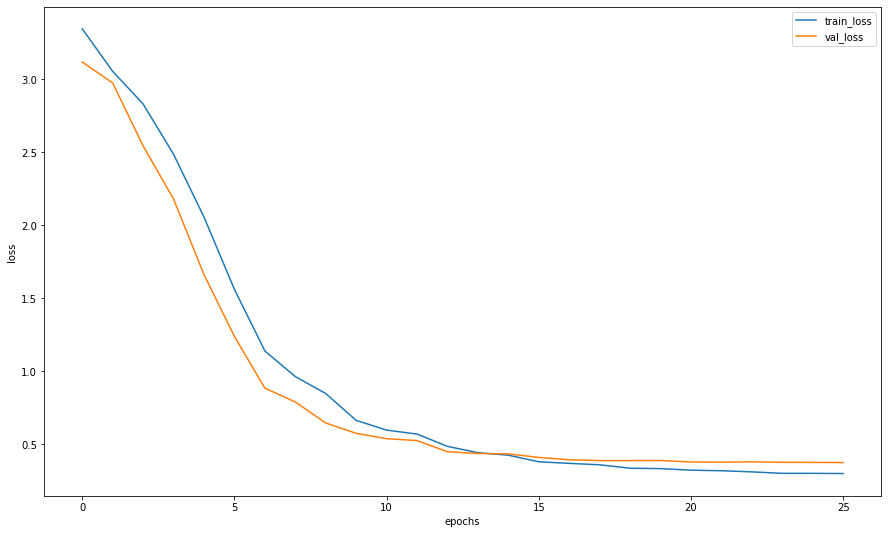

In [33]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [34]:
# save the weights of our net
model_50epoch_weights = copy.deepcopy(model.state_dict())
torch.save(model_50epoch_weights, "model_50epoch_weights.pth")

In [35]:
%ls

__notebook__.ipynb  label_encoder.pkl  model_50epoch_weights.pth


In [36]:
# загружаем сохраненное состояние весов нейросети
model.load_state_dict(torch.load("model_50epoch_weights.pth"))

<All keys matched successfully>

# What now?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [37]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [38]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [39]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

## Compare actual and predicted class ids

In [40]:
actual_labels = [val_dataset[id][1] for id in idxs]
actual_labels

[4, 6, 6, 7, 6, 4, 6, 6, 1, 0, 0, 4, 4, 5, 7, 3, 6, 4, 2, 5]

In [41]:
y_pred = np.argmax(probs_ims, -1)
y_pred

array([ 4,  6,  4,  7,  2,  4,  6,  6, 20,  0,  0,  4,  4,  5,  7,  3,  6,
        4,  2,  5])

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе - f1-score. Вычислим целевую метрику на валидационной выборке.

In [42]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='weighted')

0.8506060606060606

## Compare actual and predicted classes (strings)

In [43]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [44]:
actual_class = [label_encoder.classes_[i] for i in actual_labels]
actual_class

['bart_simpson',
 'charles_montgomery_burns',
 'charles_montgomery_burns',
 'chief_wiggum',
 'charles_montgomery_burns',
 'bart_simpson',
 'charles_montgomery_burns',
 'charles_montgomery_burns',
 'agnes_skinner',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'bart_simpson',
 'bart_simpson',
 'carl_carlson',
 'chief_wiggum',
 'barney_gumble',
 'charles_montgomery_burns',
 'bart_simpson',
 'apu_nahasapeemapetilon',
 'carl_carlson']

In [45]:
preds_class = [label_encoder.classes_[i] for i in y_pred]
preds_class

['bart_simpson',
 'charles_montgomery_burns',
 'bart_simpson',
 'chief_wiggum',
 'apu_nahasapeemapetilon',
 'bart_simpson',
 'charles_montgomery_burns',
 'charles_montgomery_burns',
 'lisa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'bart_simpson',
 'bart_simpson',
 'carl_carlson',
 'chief_wiggum',
 'barney_gumble',
 'charles_montgomery_burns',
 'bart_simpson',
 'apu_nahasapeemapetilon',
 'carl_carlson']

In [46]:
from sklearn.metrics import f1_score

f1_score(actual_class, preds_class, average='weighted')

0.8506060606060606

Сделаем классную визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

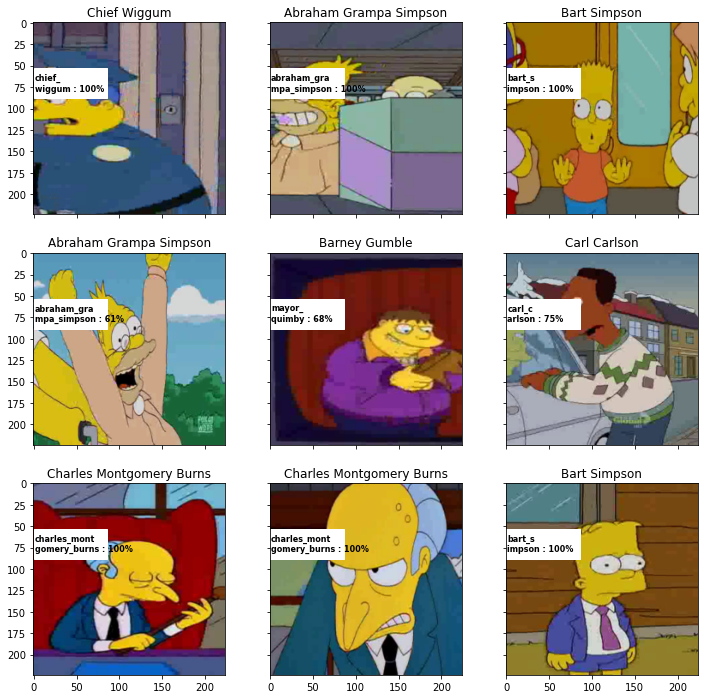

In [47]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

# Submit to Kaggle competition

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [48]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64, num_workers=4)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

# Check how the sample submission file looks

In [49]:
!ls ../input/journey-springfield

characters_illustration.png  sample_submission.csv  testset  train


In [50]:
import pandas as pd
sample_submit = pd.read_csv("../input/journey-springfield/sample_submission.csv")
sample_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [51]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
print(my_submit.shape)
my_submit.head()

(991, 2)


,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [52]:
my_submit.to_csv('resnet_submission.csv', index=False)